# Data loading and Preprocessing

## Data Loading

In [ ]:
import kagglehub
import pandas as pd
import os

# Download the dataset using kagglehub
path = kagglehub.dataset_download("rmisra/news-category-dataset")
print("Path to dataset files:", path)

# List files to find the JSON
print("Files in dataset directory:", os.listdir(path))

# Load the dataset (you should see the JSON file in the printed list)
dataset_file = os.path.join(path, "News_Category_Dataset_v3.json")
df = pd.read_json(dataset_file, lines=True)

# Preview
print(f"Shape: {df.shape}")
df.head()


100%|██████████| 26.5M/26.5M [00:00<00:00, 137MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rmisra/news-category-dataset/versions/3
Files in dataset directory: ['News_Category_Dataset_v3.json']
Shape: (209527, 6)


,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


##Filter Top 30 Categories and Combine Text Fields

In [ ]:
import numpy as np

# Get the 30 most frequent categories
top_30 = df['category'].value_counts().nlargest(30).index.tolist()
df = df[df['category'].isin(top_30)].copy()

# Replace empty short_descriptions with headline (preserve info)
df.loc[df['short_description'] == '', 'short_description'] = df['headline']
df['short_description'].fillna(df['headline'], inplace=True)

# Combine headline + short_description for the model input
df['text'] = (df['headline'] + ' ' + df['short_description']).str.lower()

# Final check
print(f"Remaining records: {df.shape[0]}")
print(f"Top categories: {df['category'].nunique()}")
print(f"categories: {df['category'].value_counts()}")
df[['text', 'category']].head()


<ipython-input-2-639abab84e42>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['short_description'].fillna(df['headline'], inplace=True)


Remaining records: 192845
Top categories: 30
categories: category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
Name: count, dtype: int64


,text,category
2,23 of the funniest tweets about cats and dogs ...,COMEDY
3,the funniest tweets from parents this week (se...,PARENTING
7,puerto ricans desperate for water after hurric...,WORLD NEWS
9,biden at un to call russian war an affront to ...,WORLD NEWS
10,world cup captains want to wear rainbow armban...,WORLD NEWS


##Label Encoding and Stratified Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode the category labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['category'])

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'],
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)
# Print summary
print(f"Total records: {len(df)}")
print(f"Number of classes: {len(le.classes_)}")
print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

Total records: 192845
Number of classes: 30
Training set: 154276 samples
Test set: 38569 samples


#Naive Base

##Vectorize Text using TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9,
    sublinear_tf=True,
    strip_accents='unicode',
    stop_words='english'
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF shape (train):", X_train_tfidf.shape)


TF-IDF shape (train): (154276, 20000)


##Train Multinomial Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, classification_report

# Train the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)


MultinomialNB()

##Evaluate Naive Base

In [ ]:
# Predict on test set
y_pred_nb = nb_model.predict(X_test_tfidf)

# Compute macro F1-score
nb_f1 = f1_score(y_test, y_pred_nb, average='macro')
print(f"Macro F1-score (Naive Bayes): {nb_f1:.4f}")

# Optional: full report
print("\nClassification Report (Naive Bayes):")
print(classification_report(y_test, y_pred_nb, target_names=le.classes_, zero_division=0))

Macro F1-score (Naive Bayes): 0.3729

Classification Report (Naive Bayes):
                precision    recall  f1-score   support

  BLACK VOICES       0.68      0.14      0.23       917
      BUSINESS       0.66      0.29      0.41      1198
        COMEDY       0.70      0.21      0.32      1080
         CRIME       0.62      0.42      0.50       712
       DIVORCE       0.94      0.36      0.53       685
 ENTERTAINMENT       0.53      0.82      0.64      3472
  FOOD & DRINK       0.76      0.72      0.74      1268
         GREEN       0.67      0.06      0.12       524
HEALTHY LIVING       0.79      0.04      0.07      1339
 HOME & LIVING       0.93      0.52      0.66       864
        IMPACT       0.73      0.06      0.11       697
         MEDIA       0.79      0.07      0.13       589
     PARENTING       0.49      0.59      0.54      1758
       PARENTS       0.71      0.03      0.05       791
      POLITICS       0.54      0.95      0.69      7121
  QUEER VOICES       0.82   

#Logistic Regression

##Train Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=200, random_state=42)
lr_model.fit(X_train_tfidf, y_train)



LogisticRegression(max_iter=200, random_state=42)

##Evaluate

In [ ]:
# Predict
y_pred_lr = lr_model.predict(X_test_tfidf)

# Evaluate
lr_f1 = f1_score(y_test, y_pred_lr, average='macro')
print(f"Macro F1-score (Logistic Regression): {lr_f1:.4f}")

# Classification report
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))

Macro F1-score (Logistic Regression): 0.5460

Classification Report (Logistic Regression):
                precision    recall  f1-score   support

  BLACK VOICES       0.58      0.38      0.46       917
      BUSINESS       0.58      0.51      0.54      1198
        COMEDY       0.61      0.42      0.50      1080
         CRIME       0.60      0.54      0.57       712
       DIVORCE       0.84      0.68      0.75       685
 ENTERTAINMENT       0.61      0.79      0.69      3472
  FOOD & DRINK       0.75      0.77      0.76      1268
         GREEN       0.55      0.38      0.45       524
HEALTHY LIVING       0.44      0.19      0.27      1339
 HOME & LIVING       0.77      0.70      0.74       864
        IMPACT       0.51      0.26      0.35       697
         MEDIA       0.65      0.37      0.47       589
     PARENTING       0.55      0.70      0.61      1758
       PARENTS       0.51      0.22      0.31       791
      POLITICS       0.70      0.88      0.78      7121
  QUEER VOIC

#LSTM

##Tokenize + Pad Sequences (LSTM)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the text data
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences
max_len = 100  # Set based on notebook or experimentation
X_train_lstm = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_lstm = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Print summary
print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Padded shape (train): {X_train_lstm.shape}")
print(f"Padded shape (test): {X_test_lstm.shape}")


Vocabulary size: 102141
Padded shape (train): (154276, 100)
Padded shape (test): (38569, 100)


##Tokenization, Padding & One-Hot Encode Labels

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
max_len = 25
X_train_lstm = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_lstm = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# One-hot encode labels
y_train_lstm = to_categorical(y_train)
y_test_lstm = to_categorical(y_test)





# Print summary
print(f"Train sequences shape: {X_train_lstm.shape}")
print(f"Test sequences shape: {X_test_lstm.shape}")
print(f"Number of classes (LSTM): {y_train_lstm.shape[1]}")


Train sequences shape: (154276, 25)
Test sequences shape: (38569, 25)
Number of classes (LSTM): 30


##Define and Train LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense

# Define model exactly as in your original notebook
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=100, input_length=300))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train_lstm.shape[1], activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2170/2170 ━━━━━━━━━━━━━━━━━━━━ 151s 67ms/step - accuracy: 0.3106 - loss: 2.5789 - val_accuracy: 0.4841 - val_loss: 1.8891
Epoch 2/10
2170/2170 ━━━━━━━━━━━━━━━━━━━━ 147s 68ms/step - accuracy: 0.5137 - loss: 1.7917 - val_accuracy: 0.5358 - val_loss: 1.6920
Epoch 3/10
2170/2170 ━━━━━━━━━━━━━━━━━━━━ 149s 69ms/step - accuracy: 0.5700 - loss: 1.5811 - val_accuracy: 0.5589 - val_loss: 1.6307
Epoch 4/10
2170/2170 ━━━━━━━━━━━━━━━━━━━━ 198s 67ms/step - accuracy: 0.6026 - loss: 1.4541 - val_accuracy: 0.5674 - val_loss: 1.5933
Epoch 5/10
2170/2170 ━━━━━━━━━━━━━━━━━━━━ 153s 70ms/step - accuracy: 0.6275 - loss: 1.3486 - val_accuracy: 0.5668 - val_loss: 1.6056
Epoch 6/10
2170/2170 ━━━━━━━━━━━━━━━━━━━━ 147s 68ms/step - accuracy: 0.6493 - loss: 1.2653 - val_accuracy: 0.5666 - val_loss: 1.6145
Epoch 7/10
2170/2170 ━━━━━━━━━━━━━━━━━━━━ 210s 72ms/step - accuracy: 0.6707 - loss: 1.1868 - val_accuracy: 0.5662 - val_loss: 1.6492
Epoch 8/10
2170/2170 ━━━━━━━━━━━━━━━━━━━━ 196s 69ms/step - accuracy: 0.6907 - lo

In [ ]:
from sklearn.metrics import f1_score, classification_report
import numpy as np

# Predict on test set
y_pred_probs = model.predict(X_test_lstm)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_lstm, axis=1)

# Macro F1-score
lstm_f1 = f1_score(y_true, y_pred, average='macro')
print(f"Macro F1-score (LSTM): {lstm_f1:.4f}")

# Optional detailed report
print("\nClassification Report (LSTM):")
print(classification_report(y_true, y_pred, target_names=le.classes_, zero_division=0))


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step
Macro F1-score (LSTM): 0.4500

Classification Report (LSTM):
                precision    recall  f1-score   support

  BLACK VOICES       0.40      0.31      0.35       917
      BUSINESS       0.36      0.39      0.37      1198
        COMEDY       0.43      0.36      0.39      1080
         CRIME       0.47      0.47      0.47       712
       DIVORCE       0.62      0.54      0.58       685
 ENTERTAINMENT       0.61      0.64      0.62      3472
  FOOD & DRINK       0.61      0.71      0.65      1268
         GREEN       0.33      0.29      0.31       524
HEALTHY LIVING       0.39      0.31      0.35      1339
 HOME & LIVING       0.59      0.55      0.57       864
        IMPACT       0.28      0.15      0.20       697
         MEDIA       0.41      0.38      0.39       589
     PARENTING       0.44      0.54      0.49      1758
       PARENTS       0.45      0.25      0.32       791
      POLITICS       0.70      0.78      0.74      71

Test Accuracy: 0.5531
Test Loss: 1.8589


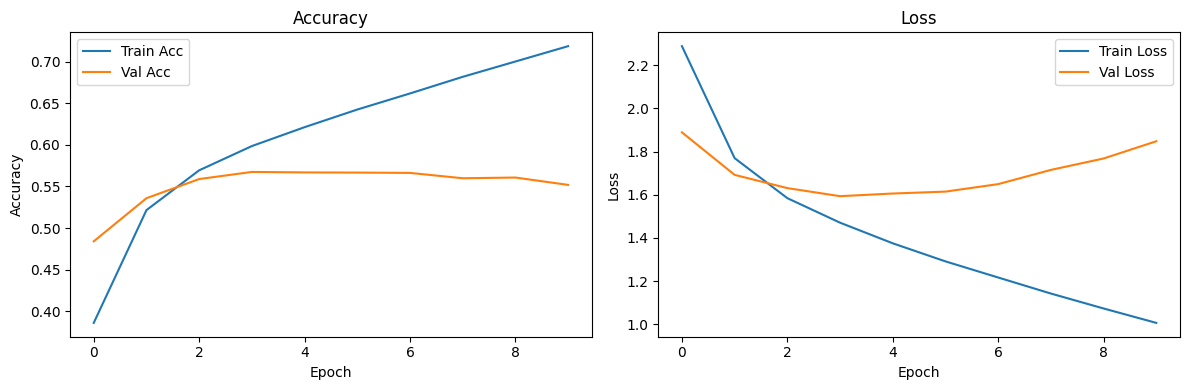

In [ ]:
import matplotlib.pyplot as plt

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, f1_score
import numpy as np

# Predict classes on test set
y_pred_probs = model.predict(X_test_lstm)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_lstm, axis=1)

# F1 Score
macro_f1 = f1_score(y_true, y_pred, average='macro')
print(f"Macro F1-score: {macro_f1:.4f}")

# Optional: Full report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step
Macro F1-score: 0.4500

Classification Report:
                precision    recall  f1-score   support

  BLACK VOICES       0.40      0.31      0.35       917
      BUSINESS       0.36      0.39      0.37      1198
        COMEDY       0.43      0.36      0.39      1080
         CRIME       0.47      0.47      0.47       712
       DIVORCE       0.62      0.54      0.58       685
 ENTERTAINMENT       0.61      0.64      0.62      3472
  FOOD & DRINK       0.61      0.71      0.65      1268
         GREEN       0.33      0.29      0.31       524
HEALTHY LIVING       0.39      0.31      0.35      1339
 HOME & LIVING       0.59      0.55      0.57       864
        IMPACT       0.28      0.15      0.20       697
         MEDIA       0.41      0.38      0.39       589
     PARENTING       0.44      0.54      0.49      1758
       PARENTS       0.45      0.25      0.32       791
      POLITICS       0.70      0.78      0.74      7121
  QUEER VOI

#LinearSVC

In [ ]:
# Import libararies

import re
import pandas as pd # CSV file I/O (pd.read_csv)
from nltk.corpus import stopwords
import numpy as np
import sklearn
import nltk
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score ,confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
news = pd.read_json('/content/News_Category_Dataset_v3.json', lines=True)
#remove_columns_list = ['authors', 'date', 'link', 'short_description', 'headline']
news['information'] = news[['headline', 'short_description']].apply(lambda x: ' '.join(x), axis=1)

FileNotFoundError: File /content/News_Category_Dataset_v3.json does not exist

In [ ]:
news.drop(news[(news['authors'] == '') & (news['short_description'] == '' )].index, inplace=True)

In [ ]:
# Split the data into train and test.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(news[['information', 'authors']], news['category'], test_size=0.33)

In [ ]:
# Convert pandas series into numpy array
X_train = np.array(X_train);
X_test = np.array(X_test);
Y_train = np.array(Y_train);
Y_test = np.array(Y_test);
cleanHeadlines_train = [] #To append processed headlines
cleanHeadlines_test = [] #To append processed headlines
number_reviews_train = len(X_train) #Calculating the number of reviews
number_reviews_test = len(X_test) #Calculating the number of reviews

In [ ]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
lemmetizer = WordNetLemmatizer()
stemmer = PorterStemmer()
def get_words(headlines_list):
    headlines = headlines_list[0]
    author_names = [x for x in headlines_list[1].lower().replace('and',',').replace(' ', '').split(',') if x != '']
    headlines_only_letters = re.sub('[^a-zA-Z]', ' ', headlines)
    words = nltk.word_tokenize(headlines_only_letters.lower())
    stops = set(stopwords.words('english'))
    meaningful_words = [lemmetizer.lemmatize(w) for w in words if w not in stops]
    return ' '.join(meaningful_words + author_names)

In [ ]:
import nltk
nltk.download('punkt_tab')

In [ ]:
import nltk
nltk.download('stopwords')


In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # Needed for some lemmatization cases
nltk.download('punkt')    # Needed for word_tokenize
nltk.download('stopwords')  # If not already downloaded


In [ ]:
for i in range(0,number_reviews_train):
    cleanHeadline = get_words(X_train[i]) #Processing the data and getting words with no special characters, numbers or html tags
    cleanHeadlines_train.append( cleanHeadline )

In [ ]:
for i in range(0,number_reviews_test):
    cleanHeadline = get_words(X_test[i]) #Processing the data and getting words with no special characters, numbers or html tags
    cleanHeadlines_test.append( cleanHeadline )

In [ ]:
vectorize = sklearn.feature_extraction.text.TfidfVectorizer(analyzer = "word", max_features=2000)
tfidwords_train = vectorize.fit_transform(cleanHeadlines_train)
X_train = tfidwords_train.toarray()

tfidwords_test = vectorize.transform(cleanHeadlines_test)
X_test = tfidwords_test.toarray()

In [ ]:
from sklearn.svm import LinearSVC

model = LinearSVC()
model.fit(X_train,Y_train)
Y_predict = model.predict(X_test)
accuracy = accuracy_score(Y_test,Y_predict)*100
print(format(accuracy, '.2f'))